In [24]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR

from libs.datasets import CDSDataset, JHUDataset
from libs.datasets import DHBeds, FIPSPopulation
from libs.datasets.dataset_utils import AggregationLevel
pd.set_option('display.float_format', lambda x: '%.2f' % x)

ImportError: cannot import name 'CDSDataset' from 'libs.datasets' (unknown location)

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# import matplotlib and related libraries
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
timeseries_data = JHUDataset.local().timeseries()
beds_data = DHBeds.local().beds()
population_data = FIPSPopulation.local().population()

In [18]:
def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4

    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': timeseries_data.get_subset(AggregationLevel.STATE).get_data(country=country, state=state),
        'beds': beds_data.get_state_level(state),
        'population': population_data.get_state_level(country, state)
    }
    
    MODEL_PARAMETERS = {        
        'model': 'seir',

        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        'presymptomatic_period': 3, # Time before exposed are infectious, In days
        'duration_mild_infections': 6, # Time mildly infected people stay sick before hospitalization or recovery, In days
        'hospital_time_recovery': 6, #Duration of hospitalization before icu or recovery, In days
        'icu_time_death': 8, #Time from ICU admission to death, In days

        'beta': 0.6,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,

        "hospitalization_rate": 0.0727,
        "hospitalized_cases_requiring_icu_care": 0.1397,
        "case_fatality_rate": 0.0109341104294479,
        
        'exposed_from_infected': True,

        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
        'observed_daily_growth_rate': 1.21,
    }
    
    MODEL_PARAMETERS['beta'] = (0.3 + ( (MODEL_PARAMETERS["observed_daily_growth_rate"] - 1.09) / 0.02) * 0.05)
    
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    [results, soln] = CovidTimeseriesModelSIR().forecast_region(
        model_parameters=MODEL_PARAMETERS
    )

    available_beds = starting_beds * (
        1 - MODEL_PARAMETERS["initial_hospital_bed_utilization"]
    )

    results["beds"] = list(
        min(
            available_beds
            * MODEL_PARAMETERS["hospital_capacity_change_daily_rate"] ** exp,
            available_beds * MODEL_PARAMETERS["max_hospital_capacity_factor"],
        )
        for exp in range(0, len(results.index))
    )

    return results    

INTERVENTIONS = [None, None, None, None]

In [19]:
#timeseries_data.get_subset(AggregationLevel.STATE).get_data('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#beds_data.get_state_level('NY')

In [20]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [21]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

In [22]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

In [23]:
df = model_state('USA', 'TX', INTERVENTIONS[0])

print(df.iloc[-1])
#print(initervention_df.iloc[-20])

df['month'] = pd.DatetimeIndex(df['date']).month
avg_doubling_month = df.loc[:, ('month', 'doubling_time')].groupby('month').mean()

plot_df(df, chart_cols)

NameError: name 'timeseries_data' is not defined

1585781555.126474
date           2020-11-25 00:00:00
total                     28995881
susceptible             1436316.82
exposed                       0.00
infected                      0.13
infected_a                    0.01
infected_b                    0.10
infected_c                    0.02
recovered              27408563.35
dead                     151000.70
beds                         66691
Name: 267, dtype: object


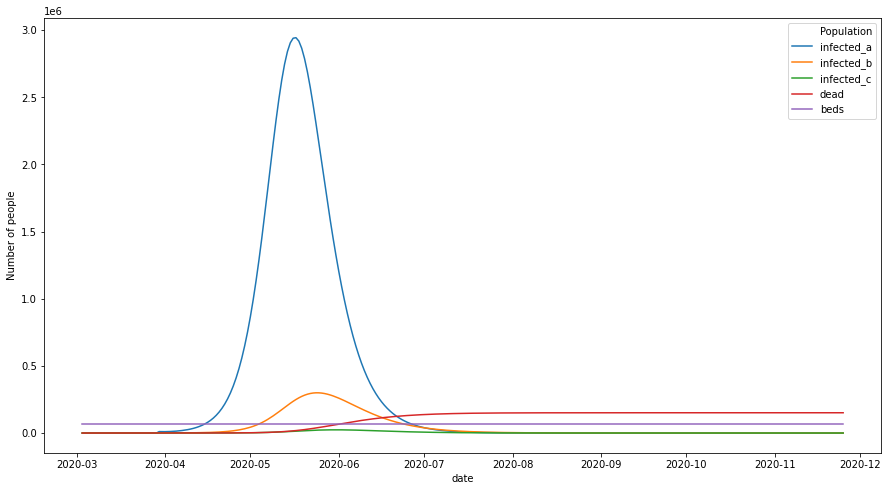

In [10]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

df['week'] = pd.DatetimeIndex(df['date']).week
avg_doubling_month = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(df, chart_cols)

In [11]:
# df.head(25)

In [12]:
[intervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

          date     total  susceptible  exposed  infected  infected_a  \
160 2020-08-10  28995881   1437128.98   134.23   2021.36      397.17   
161 2020-08-11  28995881   1437046.26   120.80   1844.88      355.73   
162 2020-08-12  28995881   1436972.14   108.74   1683.91      318.69   
163 2020-08-13  28995881   1436905.70    97.91   1537.08      285.59   
164 2020-08-14  28995881   1436846.13    88.19   1403.12      256.00   
165 2020-08-15  28995881   1436792.72    79.45   1280.91      229.54   
166 2020-08-16  28995881   1436744.81    71.59   1169.40      205.86   
167 2020-08-17  28995881   1436701.82    64.53   1067.65      184.68   
168 2020-08-18  28995881   1436663.24    58.19    974.80      165.73   
169 2020-08-19  28995881   1436628.61    52.48    890.07      148.76   
170 2020-08-20  28995881   1436597.51    47.34    812.73      133.57   
171 2020-08-21  28995881   1436569.58    42.72    742.15      119.96   
172 2020-08-22  28995881   1436544.49    38.56    677.72      10

1585781555.784714
date           2020-11-25 00:00:00
total                     28995881
susceptible             1436316.82
exposed                       0.00
infected                      0.13
infected_a                    0.01
infected_b                    0.10
infected_c                    0.02
recovered              27408563.35
dead                     151000.70
beds                         66691
Name: 267, dtype: object


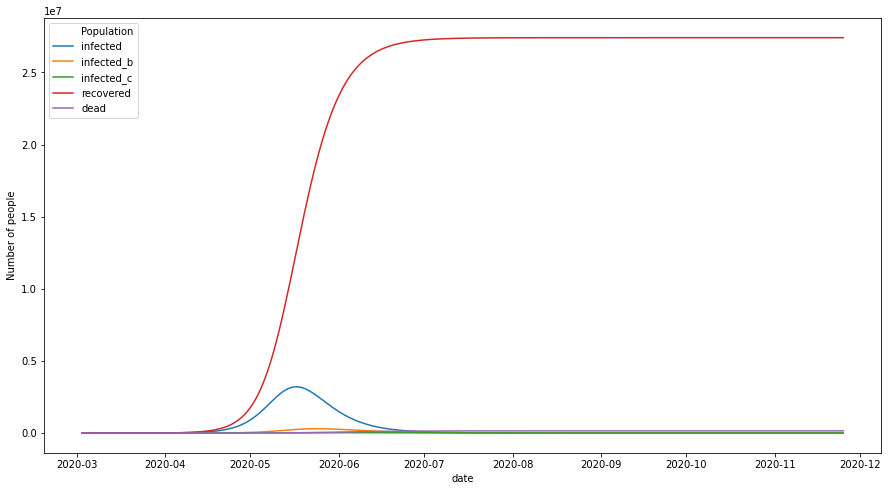

In [13]:
first_case_date = intervention_df.loc[(intervention_df.infected > 0), 'date'].min()
peak_date = intervention_df.loc[(intervention_df.infected_b == intervention_df.infected_b.max())]['date'].values[0]

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
#chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
plot_df(df, chart_cols)

[8.26467316e+07 8.27133049e+07 1.10324935e+07 9.81565123e+05
 8.61407936e+09 4.48443405e+07 8.91230752e+07]
(365, 7)


(1, 28995881.0)

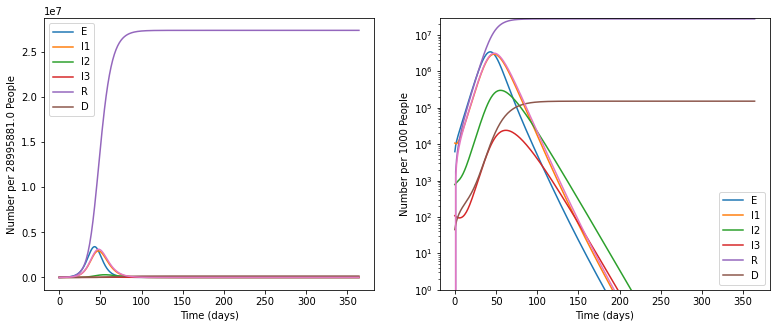

In [14]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N =  28995881.00
    #N = 10000
    tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print('avg doubling time by month')
print(avg_doubling_month)

intervention_df['week'] = pd.DatetimeIndex(intervention_df['date']).week
avg_doubling_month = intervention_df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(intervention_df, chart_cols)